# **Projet texte mining de RAA**

**Auteur**:

- James Emiliano P. QUENUM 

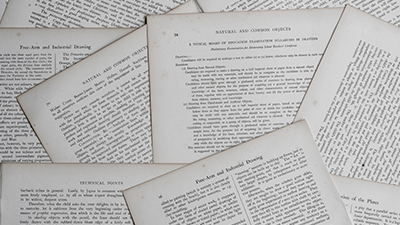

In [1]:
from IPython.display import Image
Image(filename= 'images/papers_intro.jpg', width= 500)

**Description du projet:**

**◼ Choix de notre problématique liée à la fouille de texte**

Le choix de notre problématique est lié à la fouille de texte, qui consiste à extraire et analyser des informations pertinentes à partir de documents textuels complexes, tels que les **Recueils d'actes administratifs (RAA)**. La difficulté réside dans la diversité et la complexité de ces documents, qui contiennent une variété d'éléments juridiques, tels que des visas, des articles, des informations sur les signataires, ainsi que des données géo-temporelles. L'objectif est de développer des méthodes automatisées permettant d'extraire efficacement des informations clés, d'identifier les actes en vigueur sur une période donnée, et de rendre ces données accessibles de manière intuitive pour les citoyens et les professionnels, tout en surmontant les obstacles de compréhension inhérents à la nature juridique du texte.

**- Définition du RAA [(Sources)](https://www.gironde.gouv.fr/Publications/Recueil-des-Actes-Administratifs)** :

Les recueils d'actes administratifs régionaux sont des documents juridiques complexes qui regroupent les actes réglementaires de portée générale émanant des autorités administratives de l'État, nécessitant une publicité officielle. Leur publication dans le recueil fixe la date d'entrée en vigueur de ces actes et marque le début du délai pour un éventuel recours contentieux.

Pour retrouver les actes administratifs en vigueur dans la région Bretagne sur une période donnée ou extraire une information clé contenue dans les RAA (notamment dans le cadre du droit d'accessibilité des citoyens à ces documents), il serait idéal de disposer d’un système automatisé capable de prétraiter ces documents. Un tel système faciliterait l’extraction des données essentielles, surtout lorsque ces documents sont volumineux et complexes, nécessitant parfois des compétences juridiques spécifiques pour être compris par une personne non experte.

**- Description de la structure des RAA**

Les RAA sont constitués d'un sommaire répertoriant l'ensemble des arrêtés en vigueur. Chaque arrêté est composé de visas, d'articles, ainsi que d'informations concernant l'identité des signataires et des éléments géo-temporels liés à la signature. Il est à noter que certains arrêtés peuvent ne pas comporter de visas, tout comme certains articles peuvent être absents, ce qui peut varier d'un arrêté à l'autre.

**- Choix et récupération du jeu de données**

Nous avons choisi de traiter les actes administratifs de la préfecture de la région Bretagne. Ces recueils d'actes administratifs sont accessibles sur le [site de la préfecture](https://www.prefectures-regions.gouv.fr/bretagne/Documents-publications/Recueils-des-actes-administratifs/Recueil-des-actes-administratifs) et sont disponibles depuis janvier 2019.

Concernant la récupération des données, nous avons jugé préférable de ne pas stocker les documents dans une base de données en raison des contraintes de mémoire. Nous avons ainsi opté pour une solution de scraping de la page web de la préfecture de la région Bretagne, sur laquelle les documents sont publiés. Cette approche permet une lecture et une étude temporaire des documents directement en mémoire vive.

Voici ci-dessous l'application de la fonction de récupération des liens vers les PDF des RAA par scraping :

**NB: assurer vous d'être connecté à internet tout au long des tests**

In [2]:
from database_creator import *

# Aide sur la fonction utilisée
# print(help(select_url)) 

# Test
date_de_debut= date(2024, 12, 1)
date_de_fin= datetime.today().date()

repertoire_recueil= select_url(date_de_debut, date_de_fin)
repertoire_recueil

/home/emiliano/miniconda3/envs/mas/lib/python3.11/site-packages/torch/cuda/__init__.py:716: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/emiliano/miniconda3/envs/mas/lib/python3.11/site-packages/torch/cuda/__init__.py:905: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  r = torch._C._cuda_getDeviceCount() if nvml_count < 0 else nvml_count


,url,date,ref_recueil
0,https://www.prefectures-regions.gouv.fr/bretag...,2024-12-18,r53-2024-153
1,https://www.prefectures-regions.gouv.fr/bretag...,2024-12-18,r53-2024-152
2,https://www.prefectures-regions.gouv.fr/bretag...,2024-12-17,r53-2024-151
3,https://www.prefectures-regions.gouv.fr/bretag...,2024-12-13,r53-2024-150
4,https://www.prefectures-regions.gouv.fr/bretag...,2024-12-06,r53-2024-149
5,https://www.prefectures-regions.gouv.fr/bretag...,2024-12-06,r53-2024-148
6,https://www.prefectures-regions.gouv.fr/bretag...,2024-12-03,r53-2024-147


Les documents récupérés contiennent parfois des images(souvent issue du collage d'autre document pdf au cours de l'édition), ce qui empêche la lecture et la sélection standard des chaînes de caractères. Pour résoudre ce problème, une étape de détection des chaînes de caractères présentes sur les images est appliquée à toutes les pages du document. Ce processus est appelé **reconnaissance optique de caractères** (OCR), suivi du traitement des caractères récupérés.

Cependant, cela entraîne un coût computationnel élevé, surtout lorsqu'il est nécessaire d'analyser simultanément plusieurs documents. Nous avons donc décidé de proposer un script et une application qui traitent un seul document à la fois. Il est important de noter que la précision des caractères récupérés dépend largement de la qualité de l'image contenue dans le PDF.

**◼ Pré-traitement des données à l’aide de méthodes linguistiques :**

Tout d'abord, une première phase de pré-traitement des données est initiée lors de l'extraction des constituants du RAA pour la création de la base de données associée. Ensuite, une deuxième étape de pré-traitement est intégrée dans les différents scripts de fouille de texte que nous avons développés, incluant notamment un moteur de recherche, un nuage de mots avec diverses fonctionnalités, un nuage de points issus du clustering des mots, un résumeur de RAA, un traducteur de RAA et un chatbot.

**- La première partie du pré-traitement**

+ **Extraction des composants d'un RAA**

À partir d'un recueil, nous allons utiliser les **expressions régulières** pour extraire des informations localisées sur la première page, telles que la référence du recueil et la date de publication (voir fonction « pages_to_df »). Ensuite, nous chercherons à récupérer l'intégralité du sommaire (voir fonction « extract_sommaire ») afin d'exploiter les informations qu'il contient, notamment l'intitulé des arrêtés du recueil, la référence de chaque arrêté, le nombre de pages sur lesquelles chaque arrêté est réparti, ainsi que la page de début de chaque arrêté pour en capter l'intégralité.

Pour chaque arrêté, nous utiliserons des expressions régulières pour extraire les articles et les visas, s'ils existent (voir fonction « extract_component_arr »). Nous chercherons également à extraire les informations géo-temporelles relatives à la signature de l'arrêté, telles que la ville de signature, la date de signature, ainsi que les signataires de l'arrêté (voir fonction « extract_infos_signatures »). Les signataires des arrêtés seront identifiés grâce à la **Reconnaissance d'Entités Nommées (NER)**.

Les fonctions précédemment énumérées sont contenues dans le fichier «**database_creator.py**». 

Voici l'aide associée à chacune de ces fonctions :


In [3]:
listes_fonct= [extract_sommaire, extract_component_arr,extract_infos_signatures,pages_to_df]

for fct in listes_fonct:
    f"{help(fct)}"

Help on function extract_sommaire in module database_creator:

extract_sommaire(pages)
    Fonction d'extraction du sommaire d'un recueil d'acte administratif, 
    il prend en argument les pages de l'arrêté et retourne le sommaire du document extrait

Help on function extract_component_arr in module database_creator:

extract_component_arr(pages, tuple_start_tot_page_arr, component)
    Fonction d'extraction des article d'un recueil d'actes administratif, 
    qui prend en entré une page et un tuple de la forme (numero de début de page de l'article,
    numéro de fin de page de l'arrêté et la nature du composent à extraire «"articles" ou "visas"») et 
    retourne soit la liste des numéro d'article et la liste des articles si component= articles ou 
    retourne le bloc de texte relative au visas

Help on function extract_infos_signatures in module database_creator:

extract_infos_signatures(pages, tuple_start_tot_page_arr)
    Fonction qui recupère les informations témoins du documen

À l'issue de la première partie du pré-traitement des données relatif aux RAA, après avoir récupéré les documents via le scraping et les avoir lus avec OCR, nous construisons une base de données pandas. Cette base de données est constituée des composants pré-traités extraits du recueil.

Ci-dessous la base de données extraite:

In [4]:
# Aide sur la fonction utilisée

#print(help(pdf_paths_to_df))

mon_url= [repertoire_recueil[repertoire_recueil.ref_recueil== "r53-2024-149"].url.iloc[0]] # Ceci est un recueil de court format qui ne nécessite pas beaucoup de traitement

#print(mon_url) # il s'agit de l'URL du recueil R53-2024-147

dt_frm_recueil= pdf_paths_to_df(mon_url)
dt_frm_recueil

URL 1
https://www.prefectures-regions.gouv.fr/bretagne/irecontenu/telechargement/122735/910574/file/recueil-r53-2024-149-recueil-des-actes-administratifs.pdf
Succesfull reading of arrete n°1
Succesfull reading of arrete n°2
Succesfull reading of arrete n°3


,id_recueil,date_pub_recueil,total_page_recueil,titre_arrete,nbr_arrete,articles,liste_articles_arrete,visas,repr_arrete_text,total_page_arrete,ville_signature_arrete,date_signature_arrete,signataire_arrete
0,r53-2024-149,6 décembre 2024,11,r53-2024-12-03-00002 - 2024_03 12 ar ceser_des...,3,article 1 : l'article 1er de l'arrêté du 15 dé...,[article 1 : l'article 1er de l'arrêté du 15 d...,vu la loi n° 82-213 du 2 mars 1982 relative au...,Cette arrêté est titré r53-2024-12-03-00002 - ...,2,NaN,NaN,NaN
1,r53-2024-149,6 décembre 2024,11,r53-2024-12-05-00002 - version anonyme décembr...,11,article 1er— délégation est donnée aux agents ...,[article 1er— délégation est donnée aux agents...,vu le code général des impôts et notamment s s...,Cette arrêté est titré r53-2024-12-05-00002 - ...,2,NaN,NaN,NaN
2,r53-2024-149,6 décembre 2024,11,r53-2024-12-05-00003 - version nominative déce...,11,article 1er — délégation est donnée aux agents...,[article 1er — délégation est donnée aux agent...,vu le code général des impôts et notamment son...,Cette arrêté est titré r53-2024-12-05-00003 - ...,2,NaN,NaN,NaN


**- La deuxième partie du pré-traitement**

Cette partie se concentre sur les méthodes de traitement linguistique des textes, notamment :la lemmatisation , la vectorisation TF-IDF(transformation le texte en vecteurs numériques), l'extraction de bi et  tri-grams( identification des groupes de mots consécutifs), la similarité cosinus. Afin d'éviter la redondance dans les explications, nous détaillerons ces méthodes de prétraitement au moment de présenter les scripts de fouille de texte que nous avons développés. Ces techniques sont intégrées dans les processus de traitement des données pour enrichir l'analyse des recueils d'actes administratifs.


**◼ Application des méthodes de fouille de textes choisi sur ces données**

Nous avons utilisé différentes méthodes de fouille de texte pour analyser les RAA, et nous présenterons ici leur utilité dans l'étude des recueils d'actes administratifs, ainsi que les tests effectués sur les fonctions qui les implémentent.

**- Moteur de recherche : Voir «search_engine.py»**

Le moteur de recherche que nous proposons est une méthode de fouille de texte permettant à l'utilisateur, via une phrase de recherche préalablement fournie, de retrouver les RAA les plus pertinents correspondant à sa requête, classés par ordre de pertinence. Cette approche réduit significativement le temps de recherche, la rendant plus rapide et moins fastidieuse, tout en garantissant des résultats précis et pertinents. Grâce à des algorithmes d'analyse sémantique avancée, l'outil identifie les correspondances en tenant compte des mots-clés et du contexte, offrant ainsi une expérience utilisateur optimale et efficace.

Le moteur de recherche se base sur une approche de prétraitement des textes dont un nétoyyage par expression régulière suivi d'une lémmatisation, s'en suit une vectorisation des sommaire de chacun des Receuil d'acte actministratif publié dans la période choisis. Comme expliqué précédemment, la sélection du sommaire comme corpus de vectorisation représente un compromis entre le coût computationnel et la précision de la recherche. Cette approche permet de réduire le coût d'une OCRisation de l'ensemble des documents RAA publiés, qui serait autrement beaucoup plus coûteuse en termes de ressources.

Ci suit un test de notre moteur de recherche:

In [5]:
from search_engine import *
list_tpl_ref_sommaire= recup_tuple_ref_sommaire(start_date= date_de_debut, end_date= date_de_fin)

search_text= "Santé publique"
liste_ref= similitude(list_tpl_ref_sommaire,search_text , nbr_affiche= 2)

f"Voici la liste ordonnerdes références des arrêtés {liste_ref} les plus similaire au texte de recherche «{search_text}»"


2024-12-20 10:38:21.390 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2024-12-20 10:38:21.392 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2024-12-20 10:38:21.393 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-20 10:38:21.455 
  command:

    streamlit run /home/emiliano/miniconda3/envs/mas/lib/python3.11/site-packages/ipykernel_launcher.py [ARGUMENTS]
2024-12-20 10:38:21.456 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-20 10:38:21.456 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-20 10:38:21.457 No runtime found, using MemoryCacheStorageManager
2024-12-20 10:38:21.957 Thread 'Thread-5': missing ScriptRunContext! This warning 

"Voici la liste ordonnerdes références des arrêtés ['r53-2024-150', 'r53-2024-147'] les plus similaire au texte de recherche «Santé publique»"

**- Les synthétiseurs de document : Voir «synthese.py»**

Au vue de la densité de nos données nous avons proposé trois différents types de synthétiseurs de document dont: un Nuage de mots, des clusters de mots et enfin un générateur de résumé en version ßêta.

+ **Nuage de mots :**

Nous avons choisi d'utiliser un nuage de mots car il constitue la méthode la plus claire pour obtenir une représentation de la répartition des mots dans un recueil. Cette approche met en évidence visuellement les termes les plus fréquents, avec une taille proportionnelle à leur fréquence. Le nuage de mots généré à partir de cette méthode permet ainsi de visualiser rapidement les thématiques principales d'un arrêté, contribuant à une analyse plus rapide et plus ciblée.

Pour générer le texte à traiter, nous concaténons les articles et les visas (lorsqu'ils sont présents), puis enrichissons ce corpus avec un texte récapitulatif de l'arrêté. Ce dernier est obtenu par un assemblage d'informations extraites lors de la constitution de la base de données, notamment grâce à la variable "repr_arrete_text", qui contient des éléments clés relatifs à la nature de l'arrêté, ses signataires, la date et les détails géographiques.

 Ci-dessous, nous présentons un test de cette méthode appliquée à l'un des arrêtés de notre recueil.

2024-12-20 10:39:18.958134: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-20 10:39:18.960673: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-20 10:39:18.965598: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734687558.973611   66844 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734687558.976026   66844 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been regist

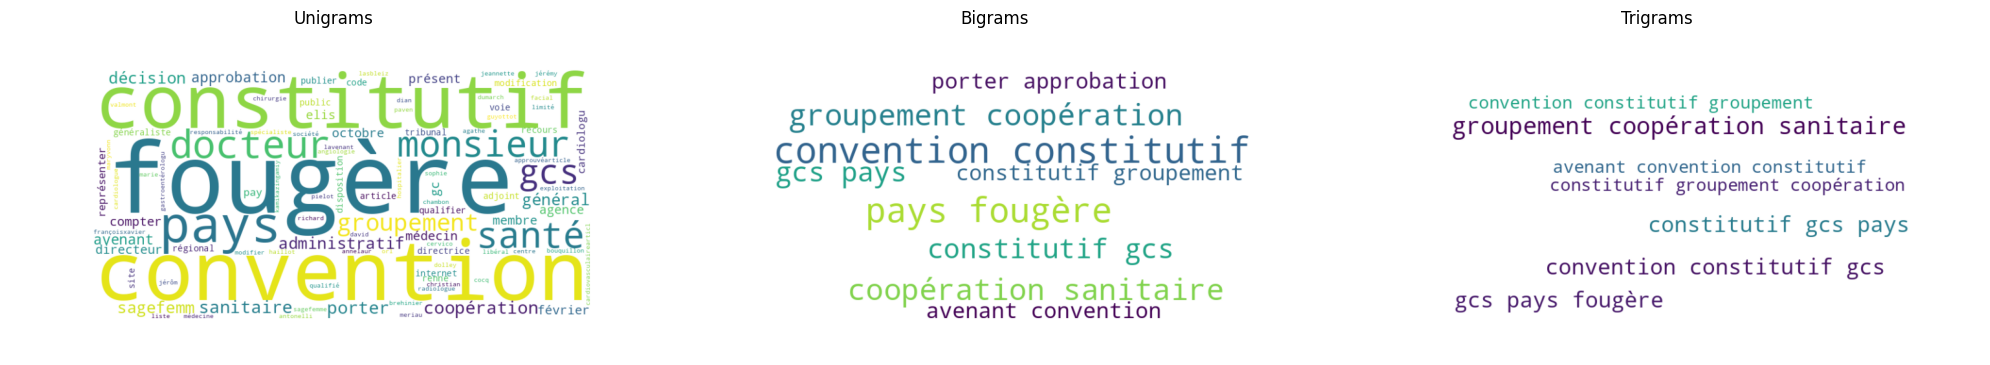

In [ ]:
# Importations nécessaires
from synthese import * 
from IPython.display import Image
%matplotlib inline


# Vérification des données
# Préparation du texte initial
articles= dt_frm_recueil["articles"][1]
articles= '' if isinstance(articles, float) else articles

visas=  dt_frm_recueil["visas"][1]
visas= '' if isinstance(visas, float) else visas

description_arrete= dt_frm_recueil["repr_arrete_text"][1]
description_arrete= '' if isinstance(description_arrete, float) else description_arrete

texte_initial = articles + visas + description_arrete
texte_nette = nettoyer_et_lemmatiser(texte_initial)

# Génération des nuages de mots
#cloud(texte_nette, nb_grams=1, max_words=100, img_title="unigram")
#cloud(texte_nette, nb_grams=2, max_words=100, img_title="bigrams")
#cloud(texte_nette, nb_grams=3, max_words=100, img_title="trigrams")


# Affichage des images save dans la même frenêtre

# Chargement des images générées
img1 = plt.imread('images/unigram.png')
img2 = plt.imread('images/bigrams.png')
img3 = plt.imread('images/trigrams.png')

# Création d'une figure avec 3 sous-graphes
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Affichage des images dans les sous-graphes
axes[0].imshow(img1)
axes[0].axis("off")
axes[0].set_title("Unigrams")

axes[1].imshow(img2)
axes[1].axis("off")
axes[1].set_title("Bigrams")

axes[2].imshow(img3)
axes[2].axis("off")
axes[2].set_title("Trigrams")

# Afficher la figure
plt.tight_layout()
plt.show()


+ **Les clusters de mots**

Nous avons conçu une méthode de visualisation des mots d'un arrêté sous forme de nuage de points, où ces mots sont regroupés en clusters spécifiques, représentant des thématiques similaires. Pour ce faire, nous avons d'abord généré des embeddings Word2Vec, qui permettent de représenter chaque mot sous forme de vecteur. Ces vecteurs sont ensuite utilisés comme entrée pour un algorithme de clustering K-means, configuré pour identifier plusieurs clusters de mots. Cette approche permet de regrouper les mots ayant des significations ou contextes similaires, facilitant ainsi l'analyse sémantique du texte.

Une fois les clusters formés, nous affichons un nuage de points représentant les mots, avec une mise en avant du mot le plus représentatif de chaque cluster. Cela permet d’offrir une visualisation plus claire et intuitive des principales thématiques présentes dans l'arrêté. 

Ci-dessous, nous présentons un exemple de cette méthode de fouille de texte appliquée à l'un des arrêtés de notre recueil, illustrant la distribution des mots et leurs clusters associés.

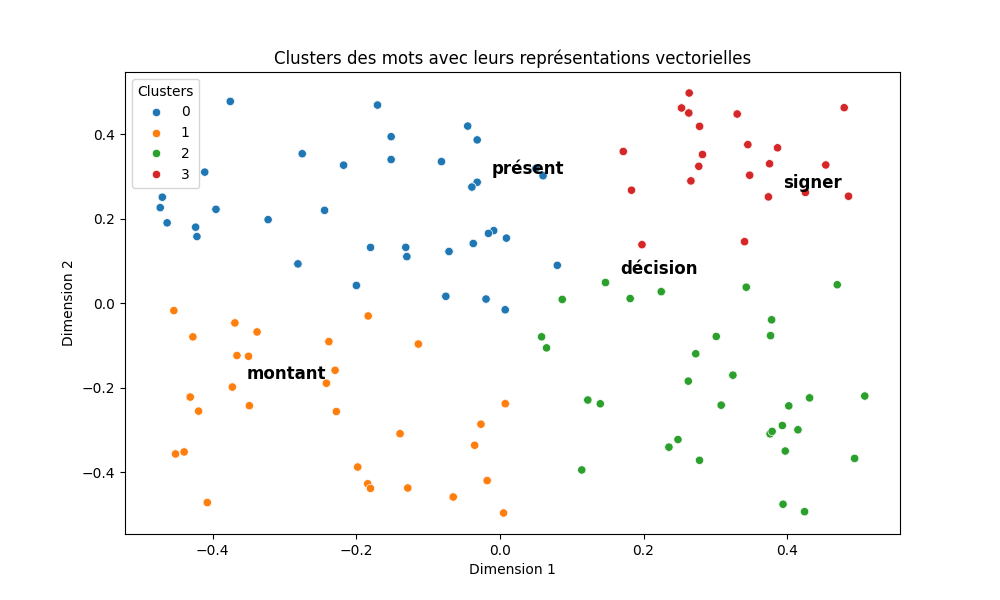

In [26]:
# Création de la représentation vectoriel
#repr_vectoriel(texte_initial, nb_clust= 4)

# Affichage de l'image save
Image(filename= 'images/cluster_mots.png')

+ **Générateur de résumé - ßêta**

Pour simplifier leur compréhension, nous avons décidé de les résumer. Étant donné les coûts computationnels et les limites de précision des outils de résumé automatique, nous avons choisi une approche qui consiste à résumer chaque arrêté individuellement.

Pour ce faire, nous avons utilisé un modèle de tokénisation et de résumé de texte de type "facebook/bart-large-cnn", qui est bien adapté pour la tâche de résumé automatique, associé à un reformulateur de type "facebook/bart-large". Cette combinaison a été choisie pour surmonter une contrainte importante : les arrêtés dépassent souvent le nombre maximal de tokens (environ 1024 tokens) que les modèles de résumé peuvent traiter efficacement. Pour y remédier, nous découpons le texte initial en segments respectant cette limite, puis chaque segment est résumé séparément.

Cependant, cette méthode produit des résumés partiels qui peuvent parfois manquer de cohérence globale. Afin d’améliorer la fluidité du résumé final, nous avons intégré un reformulateur de texte. Ce dernier permet de rendre le résumé plus concis, cohérent et facilement compréhensible. Un avantage notable de cette approche est que, lors de chaque exécution, le reformulateur peut générer un résumé légèrement différent et souvent plus précis par rapport à la version précédente, ce qui améliore la qualité du résumé au fur et à mesure des essais.

Ci-dessous, nous présentons la méthode de fouille de texte basée sur le générateur de résumé (version bêta), testée sur l'un des arrêtés de notre recueil.

In [8]:
great_summary(texte_initial)

Your max_length is set to 1024, but your input_length is only 366. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=183)
Your max_length is set to 1024, but your input_length is only 387. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=193)
Your max_length is set to 1024, but your input_length is only 360. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=180)
Your max_length is set to 1024, but your input_length is only 363. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_leng

'Délégation est donnée aux agents dont les numéros de commission d’emploi figurent en annexe i de la présente décision à l’effet de signer. Actes transactionnels définitifs de type 406 portant sur des contentieux voyageurs en matière de contravention et de délit douaniers pour les montants.L’ancien président de la direction régionale des douanes a annoncé le précédent de la nouvelle présentation des actes administratifs du département du siège, au nom du directeur interrégional à nantes. Dans le cadre de cette annonce, la précision sera publiée au recueil des acte administrativs du déspartement.Délèvement sur les actes de commission et de compétition d‘emploi dans les annexes vii et viii de la pouvoir de prévoir. D’autres actes. Délêvement. Désolée. DÉLÏVEMENTSDéclarement. Acte transactionnel défintifs.DÉLÉVEMENTEMENTS:Déleveement. Act. Acta. Acteur. Actus. Actué.'

# Pour aller plus loins

Nous avons proposé deux autres méthodes de fouille de texte : l'une basée sur la traduction automatique et l'autre sur la génération automatique de texte. Nous n'avons pas développé nos propres modèles de génération de texte, car cela aurait nécessité des ressources importantes, tant en termes de calcul que de temps. Étant donné les contraintes temporelles du projet, nous avons opté pour l'utilisation de modèles existants, plus adaptés à nos besoins immédiats.

**- Traducteur linguistique de RAA: Voir «translator.py»**

Les Recueils des Actes Administratifs (RAA) contiennent des informations réglementaires et administratives cruciales qui peuvent concerner des publics variés, y compris des citoyens ou professionnels dont la langue maternelle n'est pas le français. 

Dans notre démarche de traduction linguistique des Recueils des Actes Administratifs (RAA), nous avons limité l'étendue du corpus à traduire à un seul arrêté à la fois. Cette stratégie permet de réduire la taille du texte traité et d'augmenter en conséquence la précision de la traduction.

Pour cette tâche, nous avons choisi d’utiliser le modèle de traduction «**facebook/m2m100_418M**», associé à son tokeniseur «**M2M100Tokenizer**». Ce modèle a la capacité de traduire jusqu’à 100 langues différentes, répertoriées dans un fichier de configuration nommé «langues.json».

Le modèle **facebook/m2m100_418M** fait partie de la famille des modèles multilingues développés par Facebook AI.  Il est spécialement conçu pour la traduction automatique entre plusieurs langues sans nécessiter de pivot par une langue intermédiaire, comme l'anglais, ce qui est courant dans d'autres modèles multilingues.

Ci-dessous une illustration de la traduction linguistique:

In [9]:
from translator import *
from pprint import pprint

texte_initiale, ma_traduction = traduction(texte= texte_initial, lang_initiale= "fr" , lang_cible= "en")

In [10]:
print("***************************Texte inintial****************************************\n")
pprint(''.join(texte_initiale.split(".")[:5]))
print("*********************************************************************************\n")


***************************Texte inintial****************************************

('article 1er— délégation est donnée aux agents dont les numéros de commission '
 'd’emploi (matricules) figurent en annexe i de la présente décision à l’effet '
 'de signer, au nomdu directeur  interrégional à nantes, les décisions de '
 'nature contentieuse (décharge de droits suite à - réclamation, décision sur '
 'les contestations en matière de recouvrement des articles l 281 et l 283 du '
 'livre des procédures fiscales, rejet d’une réclamation, restitution ou '
 'remboursement de droits suite à erreur sur l’assiette, réduction de droits '
 'suite à erreur de calcul) en matière de contributions indirectes, et pour '
 'les montants maximaux qui sont mentionnés, dans cette même annexe [, en '
 'euros ou pour des montants illimitésarticle 2 - délégation est donnée aux '
 "agents dont les numéros de commission d'emploi (matricules) figurent en "
 'annexe ii de la présente décision à l’effet de signer, 

In [11]:
print("***************************Texte Traduit****************************************\n")

pprint(''.join(ma_traduction.split(".")[:8]))
print("********************************************************************************\n")


***************************Texte Traduit****************************************

('Article 1 – Delegation is given to the agents whose employment committee '
 'numbers (matricules) are listed in Annex i to this Decision in order to '
 'sign, on behalf of The Director Interregional in Nantes, disputed decisions '
 '(release of rights following a complaint, decision on disputes regarding the '
 'recovery of Articles 281 and 283 of the Tax Procedure Book, rejection of a '
 'complaint, refund or refund of rights following error on the plate, '
 'reduction of rights following error of calculation) in relation to indirect '
 'contributions, and for the maximum amounts mentioned in the same Annex [, in '
 'euros or for unlimited amounts] Article 2 - Delegation is given to the '
 'agents whose employment commission numbers (matricules) are listed in Annex '
 'ii to the effect of signing, on behalf of the interregional director at '
 'Nantes, the decisions of gracious nature (decision on reque

**- Agent conversationnel voir «generative_ai.py»**

Nous avons également proposé une IA générative visant à faciliter les requêtes des utilisateurs et à leur fournir des réponses précises et adaptées à leurs besoins. Cette solution repose sur des modèles de traitement du langage naturel capables de reformuler ou de compléter les questions, même lorsqu'elles sont imprécises ou mal formulées, garantissant ainsi une correspondance optimale avec les données des RAA. 

De manière similaire à ce qui a été mentionné dans l’introduction du traducteur linguistique, nous n’avons pas développé le modèle d’IA générative, mais avons utilisé un modèle déjà existant : il s'agit du modèle **«google/bigbird-roberta-base»** de Google.Ce modèle a été choisi en raison de sa capacité à traiter de grandes quantités de données tout en préservant une grande précision dans l’interprétation des requêtes. Son architecture est adaptée pour comprendre le contexte des questions et en générer des réponses pertinentes.

In [12]:
from generative_ai import *

question = "quel est le nombre d'arrêté contenu dans ce recueil?"
conv_agent(question, texte_initial)

Some weights of BigBirdForQuestionAnswering were not initialized from the model checkpoint at google/bigbird-roberta-base and are newly initialized: ['qa_classifier.intermediate.dense.bias', 'qa_classifier.intermediate.dense.weight', 'qa_classifier.output.LayerNorm.bias', 'qa_classifier.output.LayerNorm.weight', 'qa_classifier.output.dense.bias', 'qa_classifier.output.dense.weight', 'qa_classifier.qa_outputs.bias', 'qa_classifier.qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Input ids are automatically padded from 1934 to 1984 to be a multiple of `config.block_size`: 64


' articles 350-et'

Vous avez pu sans doute constater le niveau de précision de notre IA générative. L'objectif est d'adapter plus tard ce modèle spécifiquement à nos données en utilisant des techniques d'apprentissage supervisé sur celles-ci, afin d'améliorer encore sa performance et sa pertinence dans notre contexte. Ce processus d'adaptation permettra d'affiner le modèle pour qu'il réponde de manière plus précise et adaptée à nos besoins.

# Application streamlit récapitulatif


Afin d'optimiser l'utilisation des fonctionnalités de fouille de texte, nous avons développé une interface graphique interactive via Streamlit. 

Notice: Pour assurer le bon fonctionnement de l'application, veuillez installer tous les packages listés dans le fichier **requirements.txt** en utilisant la commande **pip install -r requirements.txt**, ou bien décommenter la première ligne du fichier de l'application **texte_mining_RAA**. Pour les tests sur l'application privilégiez les recueils de petits taille telle que le r53-2024-147 ou le r53-2024-149 par exemple, il ne contiennent que deux à tris arrêté.
            

**Lancement de l'application**

Une fois les packages installés pour démarrer l'application, il faut exécuter le fichier « texte_mining_RAA.py ». À la fin de l'exécution, cliquez sur le premier lien localhost affiché dans la console. Vous trouverez ci-dessous une illustration visuelle :

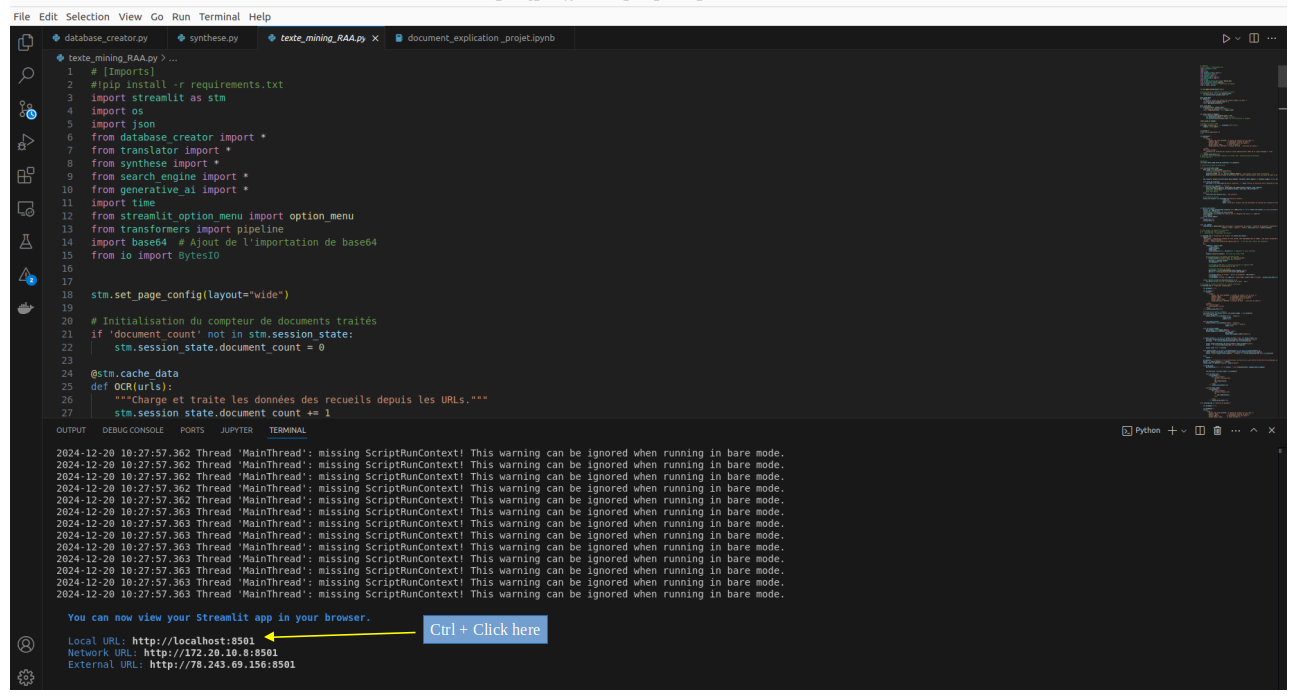

In [21]:
Image(filename= 'images/process_run_apk.png')

L'application est composé de 4 rubrique notamment:


- **un visualiseur de recueil** 

Dans cette onglet, nous avons intégré un moteur de recherche précédemment implémenté ainsi qu'un visualiseur de PDF permettant de visualiser et d'interagir avec le recueil recherché. Vous pouvez choisir un intervalle de dates de publication des recueils, et une liste des recueils publiés vous sera alors affichée. Par défaut, tous les recueils sont inclus dans la liste des références, et la recherche permet de sélectionner les trois recueils les plus pertinents en fonction de votre phrase de recherche, classés du plus important au moins pertinent.

Voir l'image ci-dessous :

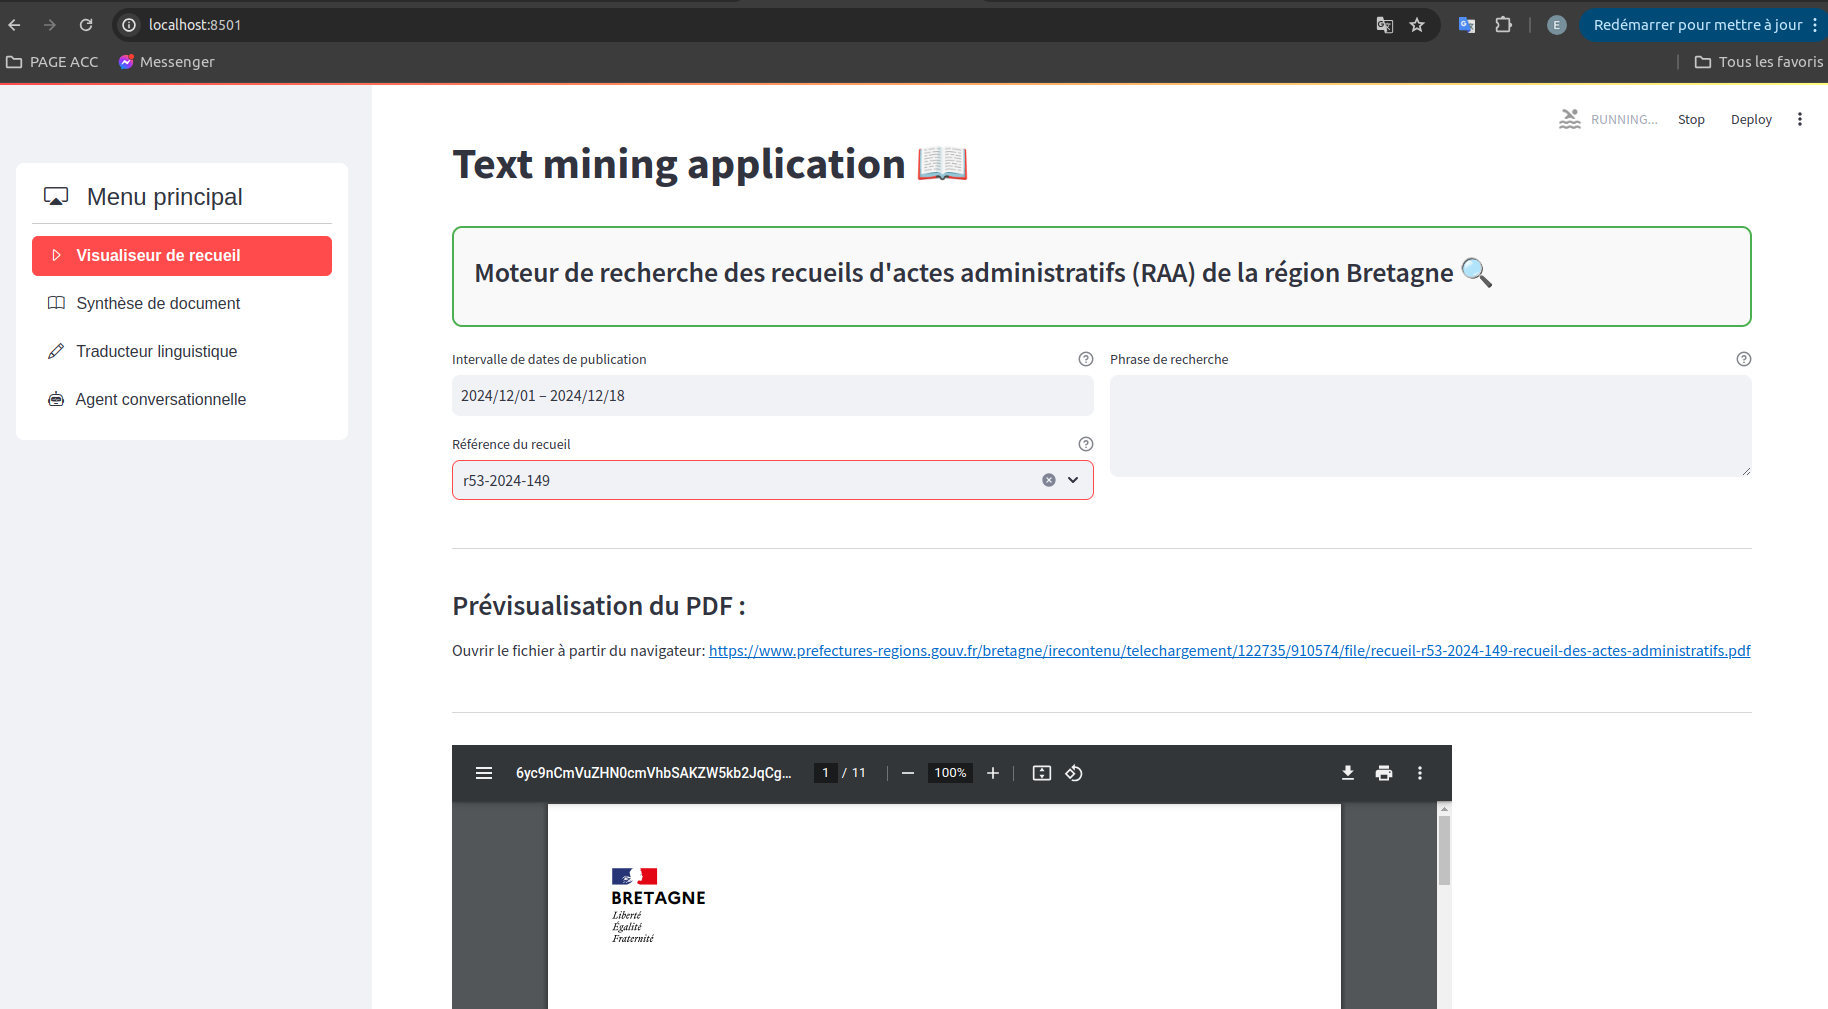

In [14]:
Image(filename= 'images/visualiseur_1.png')

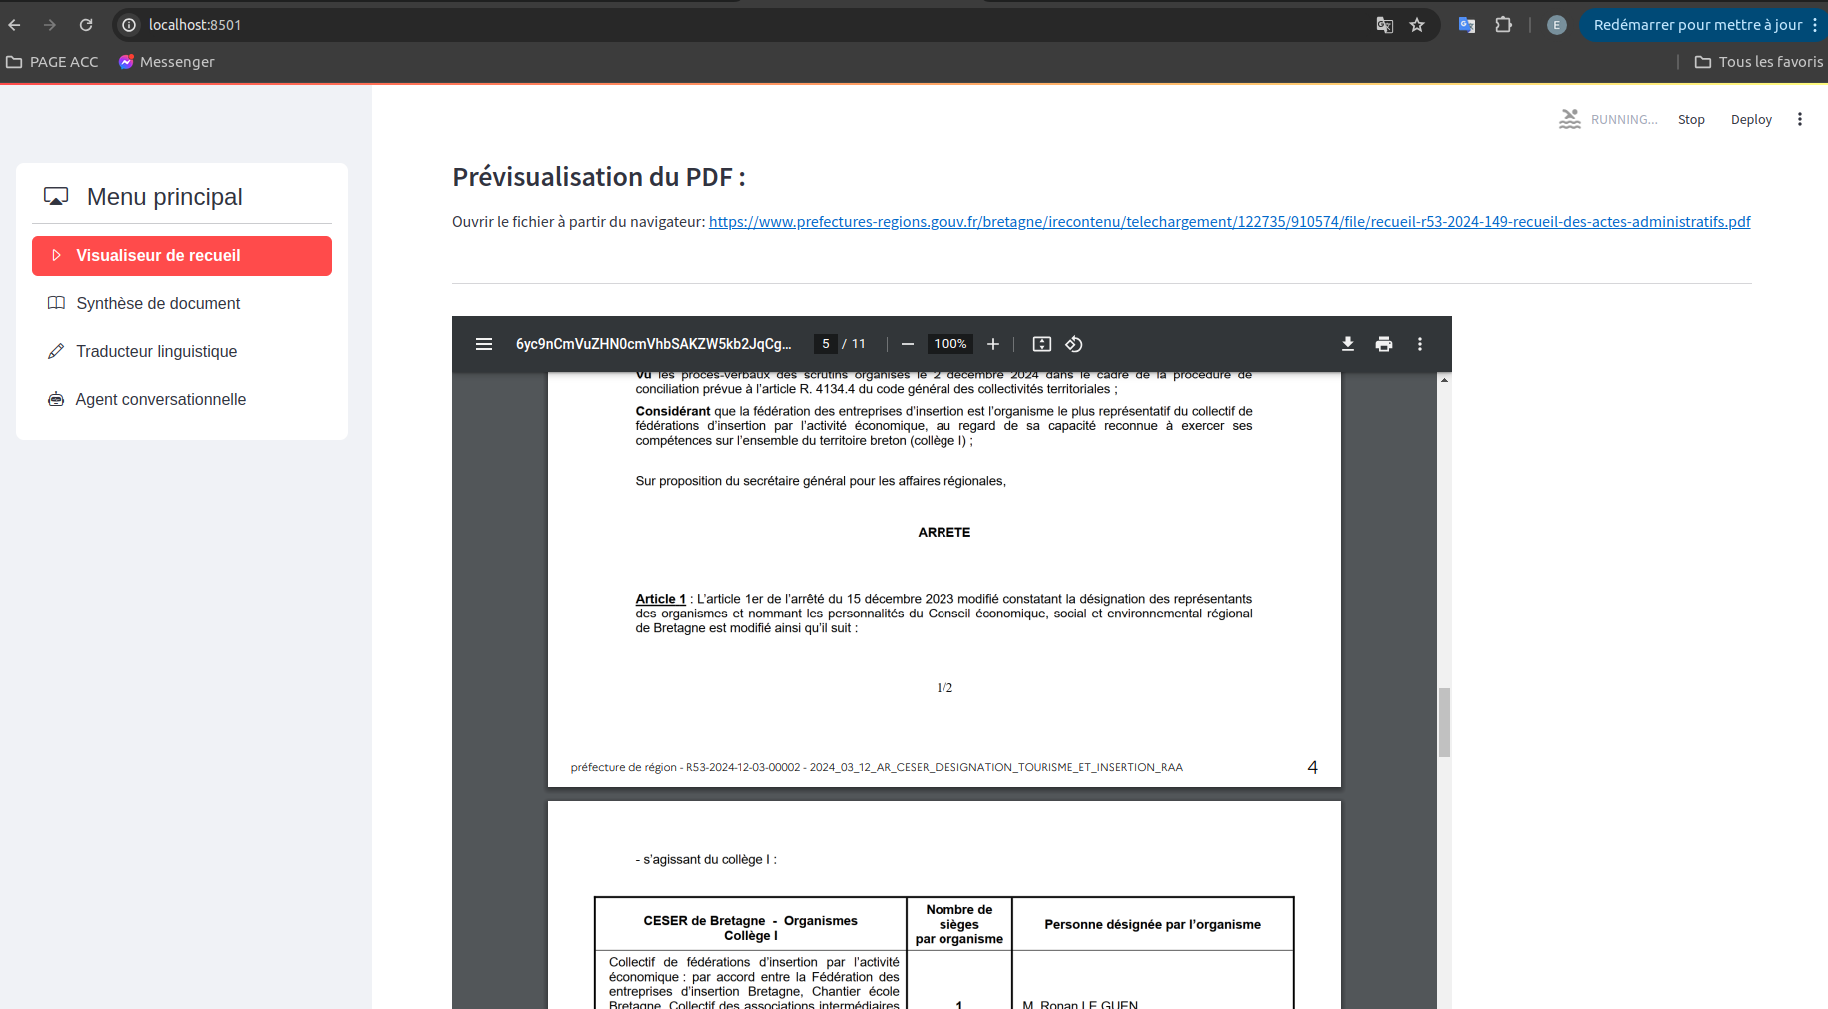

In [15]:
Image(filename= 'images/visualiseur_2.png')

**- Synthèse de document**

Trois modes de résumé sont disponibles dans cette onglet :
+ **Le nuage de mots**

Pour créer le nuage de mots, la manipulation est simple : il suffit de choisir un type de représentation n-gramme, où $n \in [1, 2, 3]$, ainsi qu'un nombre total de n-grammes à afficher. Ci-dessous, une illustration :

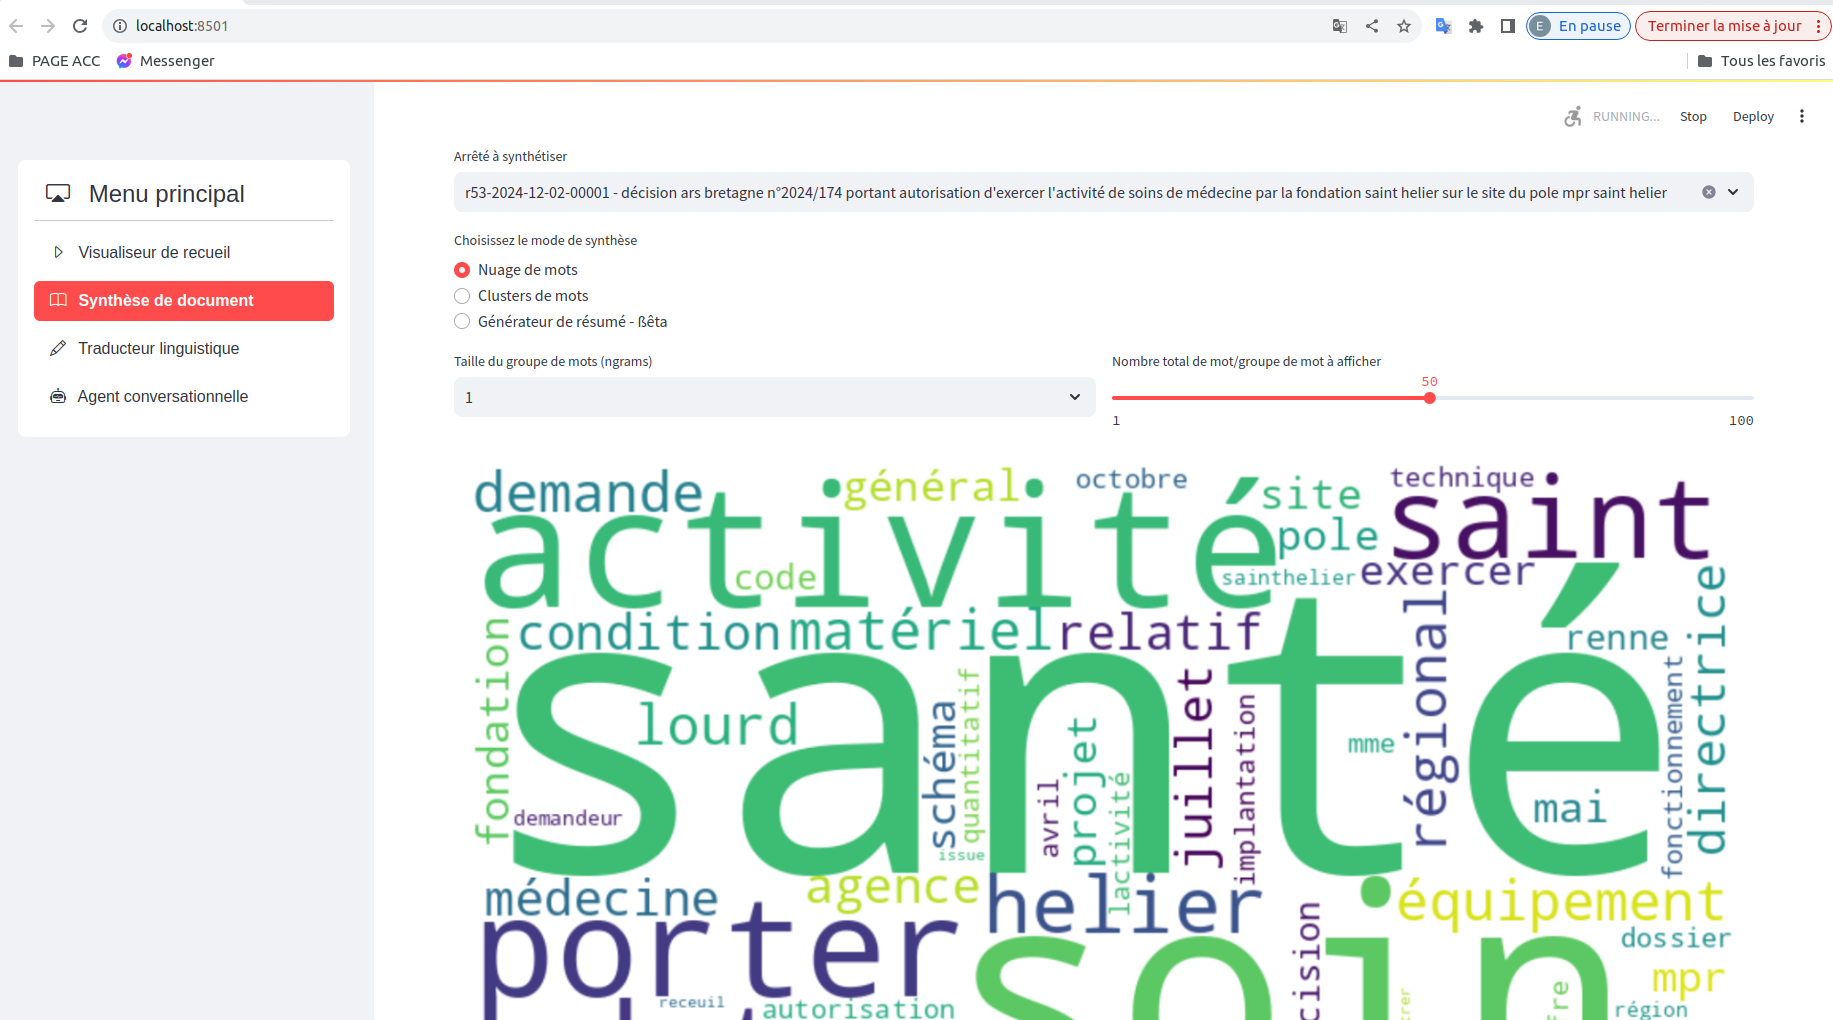

In [16]:
Image(filename= "images/nuage_de_mots.png")

+ **Clusters de mots**

Pour visualiser les clusters de mots, il suffit de sélectionner un arrêté à analyser ainsi que le nombre de clusters à générer. Une fois ces choix effectués, une visualisation automatique des clusters est produite.

Ci-dessous, un exemple de visualisation de ces clusters :

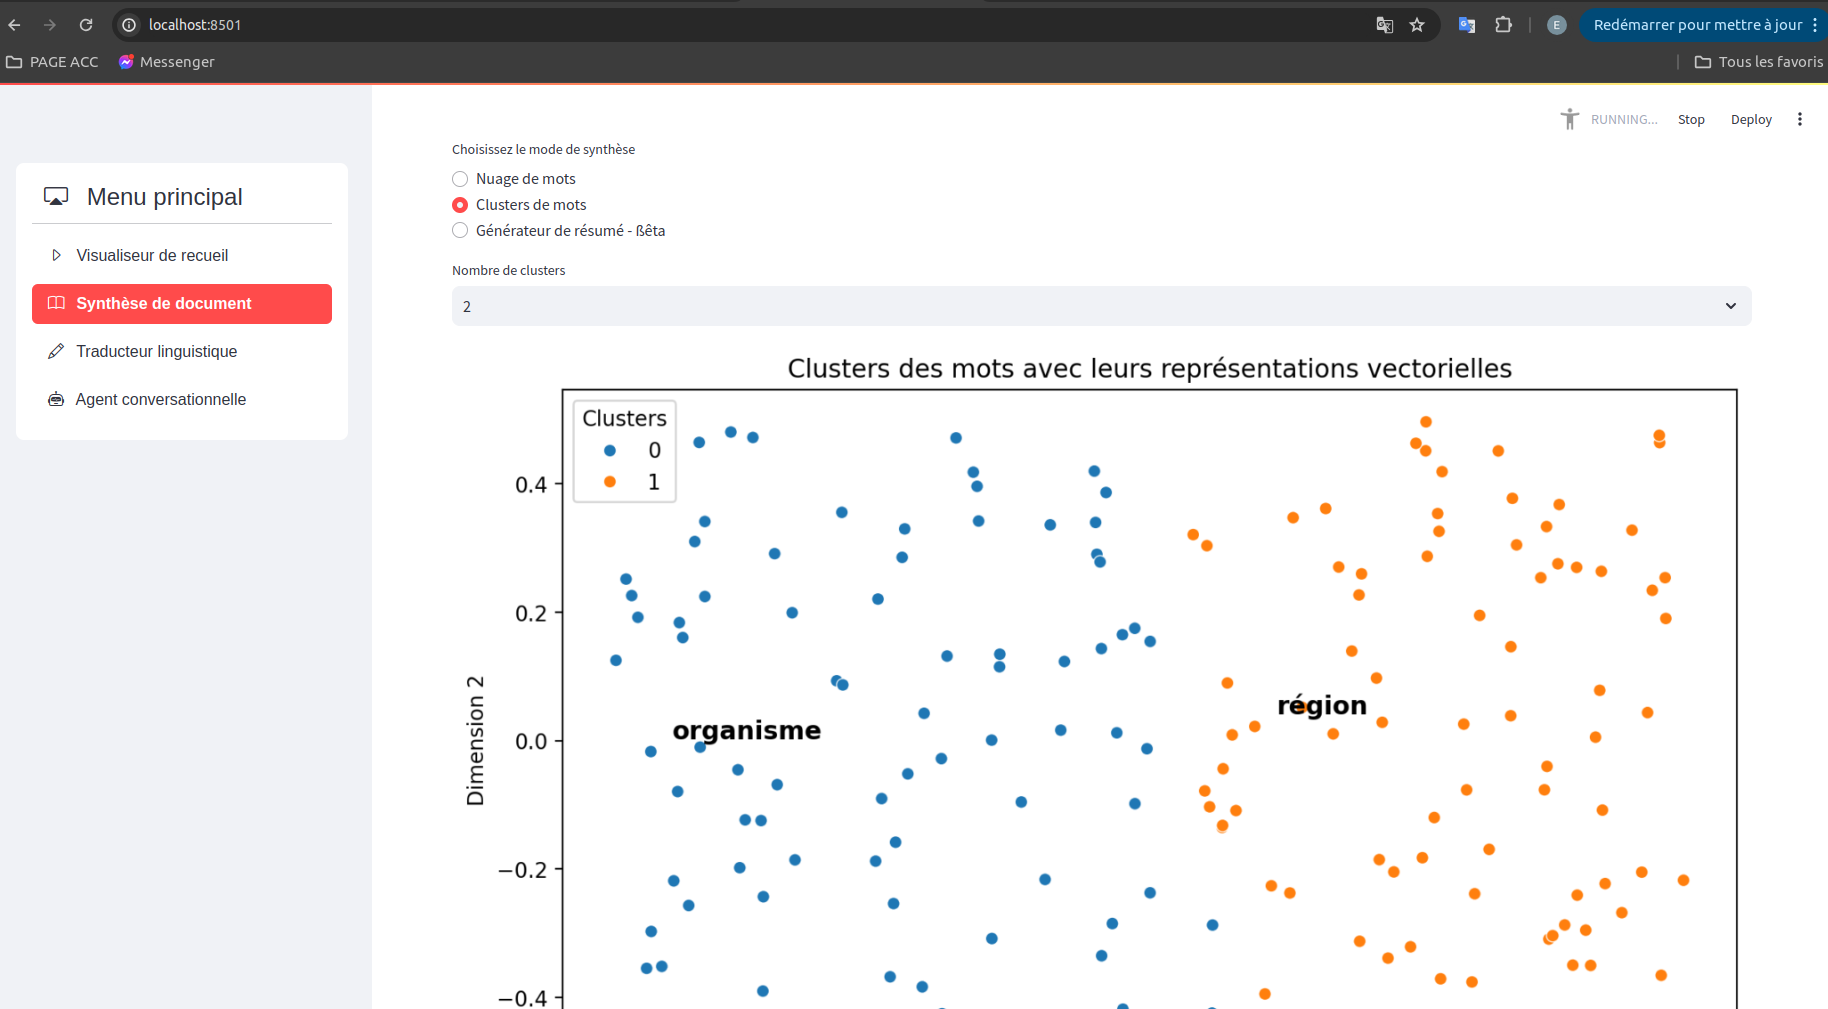

In [17]:
Image(filename= "images/clusters_word.png")

+ **Générateur de résumé - ßêta**

Le Générateur de résumé Bêta n'est autre que notre résumeur précédemment présenté. Il se lance automatiquement pour proposer un résumé de l'arrêté, et se met à jour en générant d'autres résumés lorsque l'on clique sur le bouton "Rafraîchir".

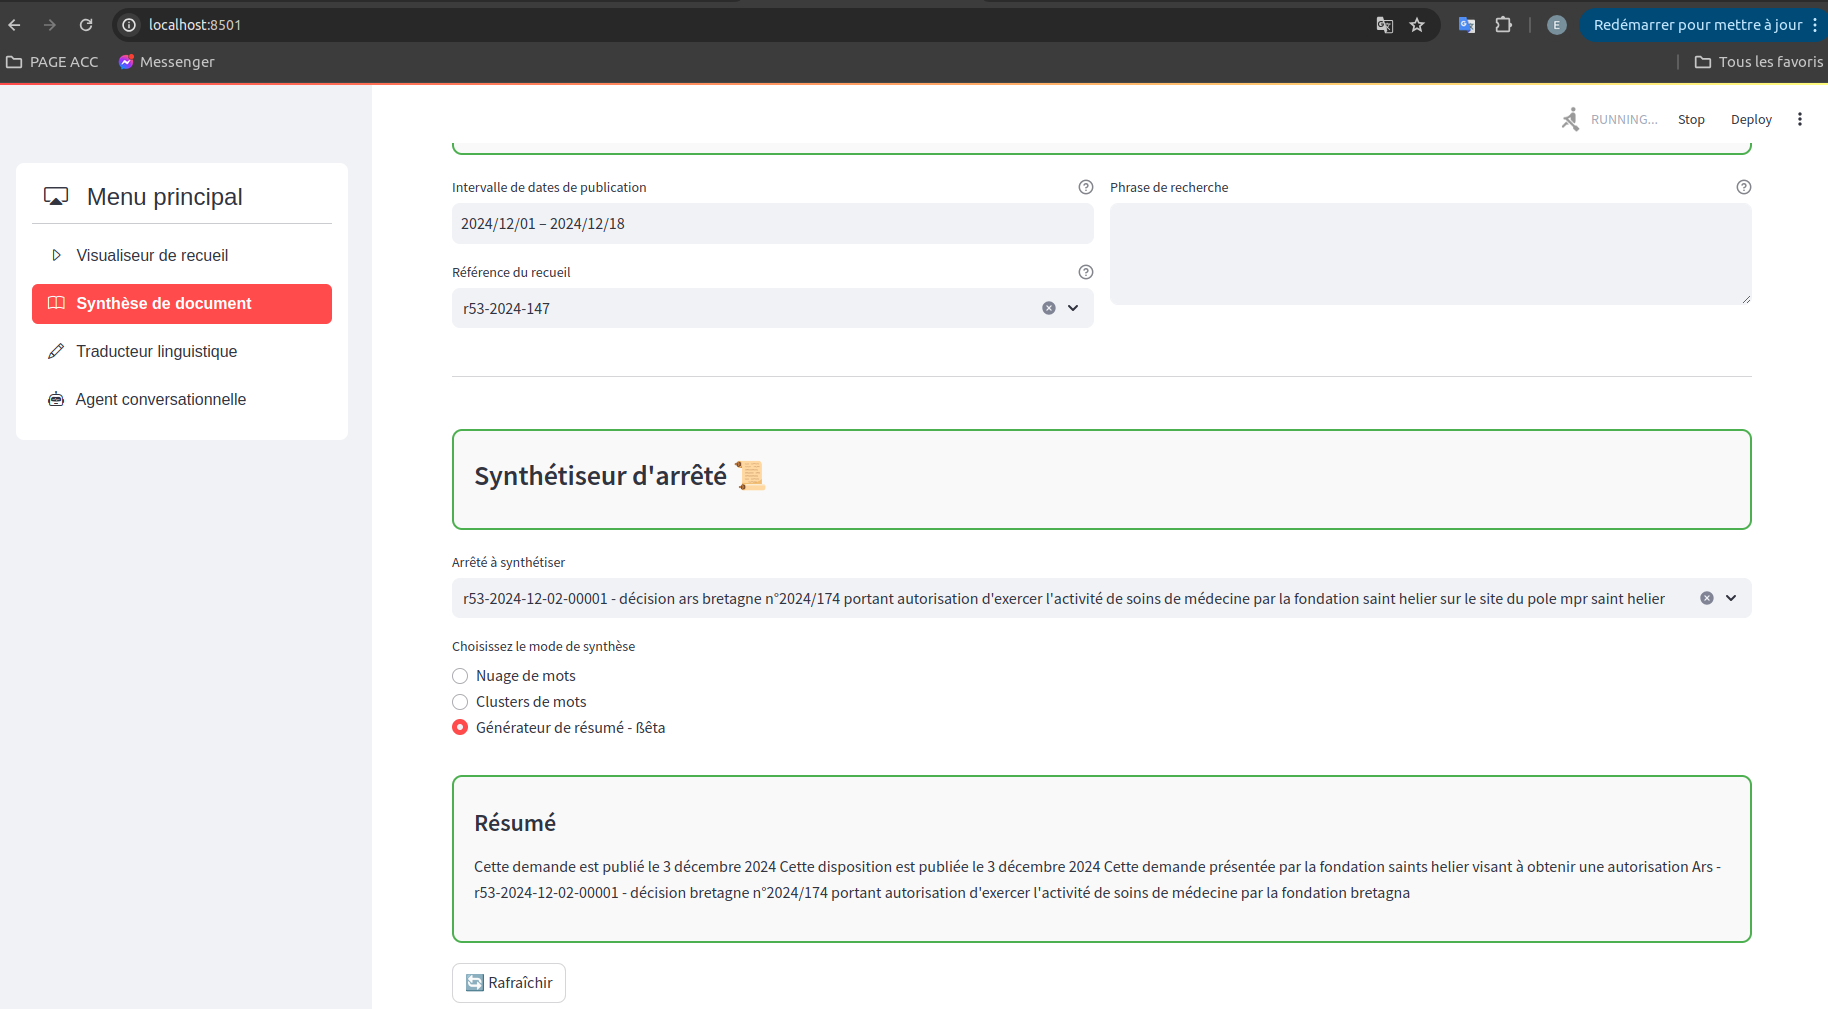

In [18]:
Image(filename= "images/generate_resum.png")

**- Traducteur linguistique**

Cette fonctionnalité permet de traduire une ou plusieurs composantes de l'arrêté, notamment les articles, les visas, ou même les deux. Pour l'utiliser, il suffit de choisir un arrêté, sélectionner la composante à traduire, choisir la langue, puis de cliquer sur le bouton "Traduire".

Nous vous invitons à découvrir cette fonctionnalité à travers l'exemple suivant :

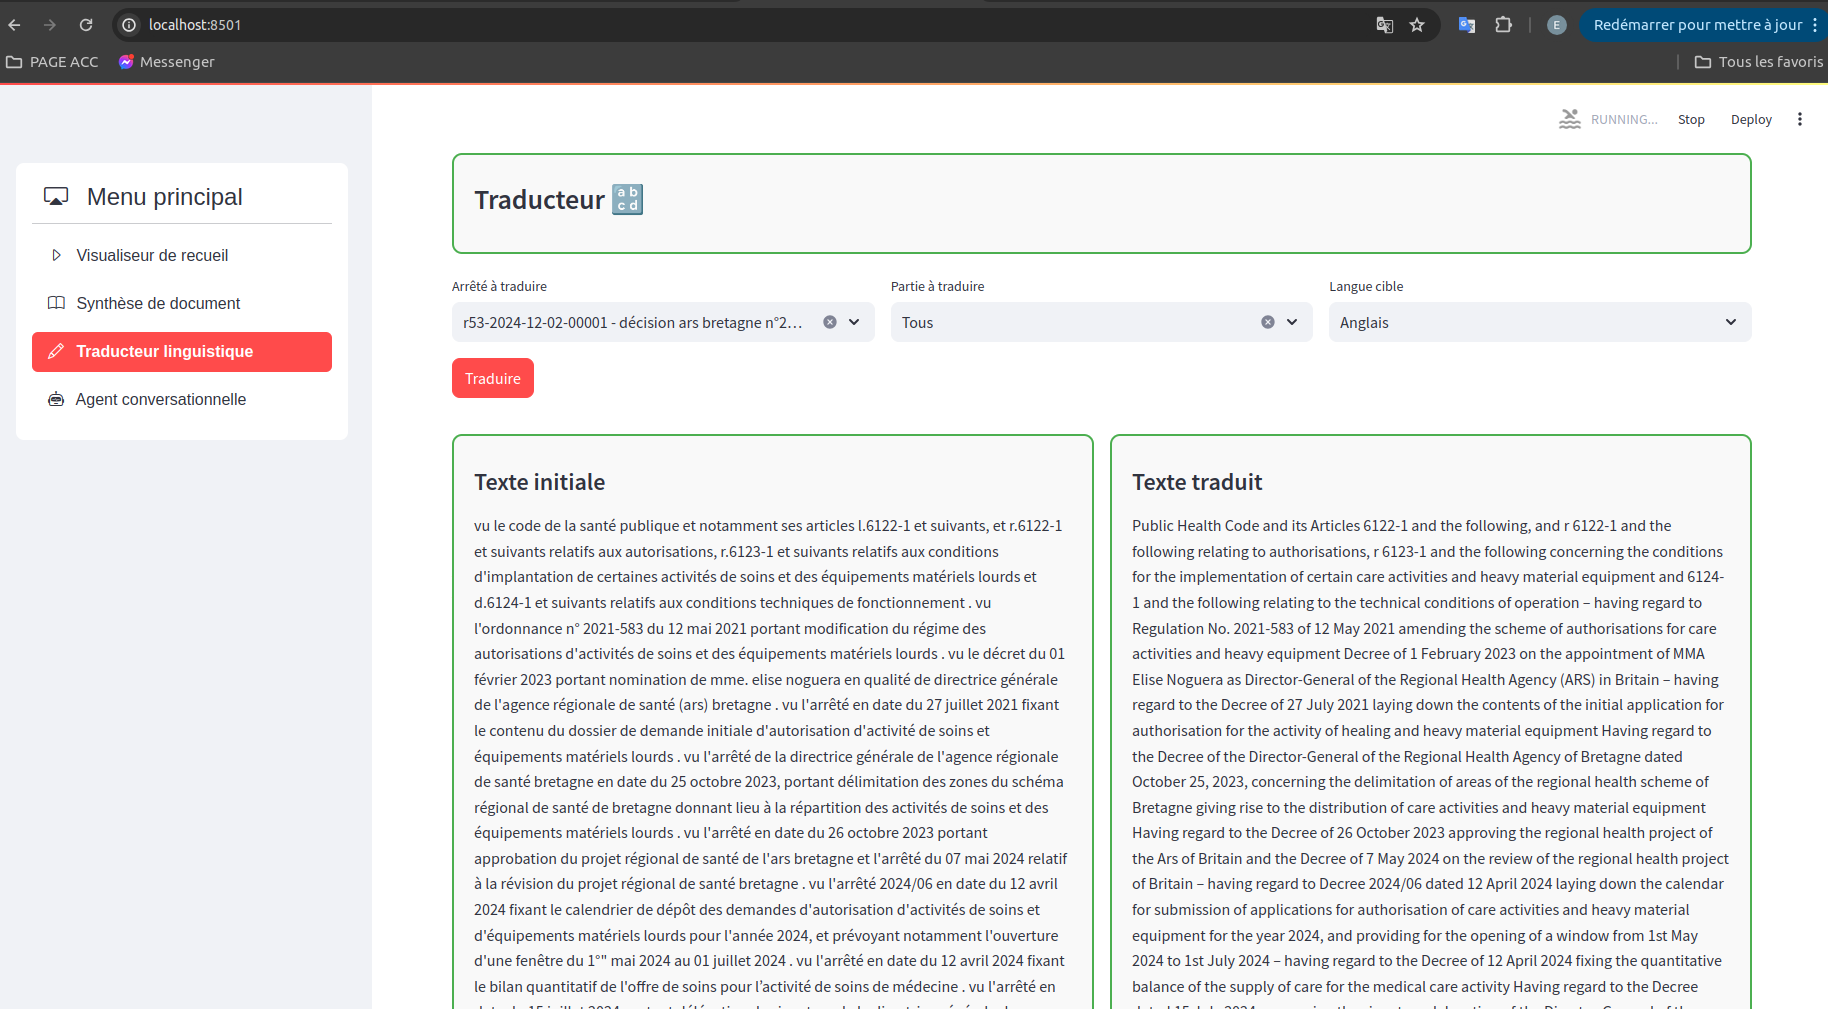

In [19]:
Image(filename= "images/traducteur_lang.png")

**- Générateur AI - ßêta**

La fonctionnalité du générateur IA Bêta est un générateur de réponses qui se base sur les données de l'arrêté du RAA qui lui ont été préalablement fournies.

Pour utiliser cette fonctionnalité, il suffit de sélectionner un article du recueil, puis de l'envoyer en cliquant sur le bouton "Envoyer". Il est également possible de consulter l'historique de la conversation avec l'agent conversationnel. Pour supprimer l'historique et rafraîchir, utilisez le bouton "Rafraîchir".

Ce générateur n'est pas encore totalement performant, il est donc recommandé de poser la même question plusieurs fois pour obtenir une réponse plus précise (pensez à rafraîchir avant de renvoyer la question).

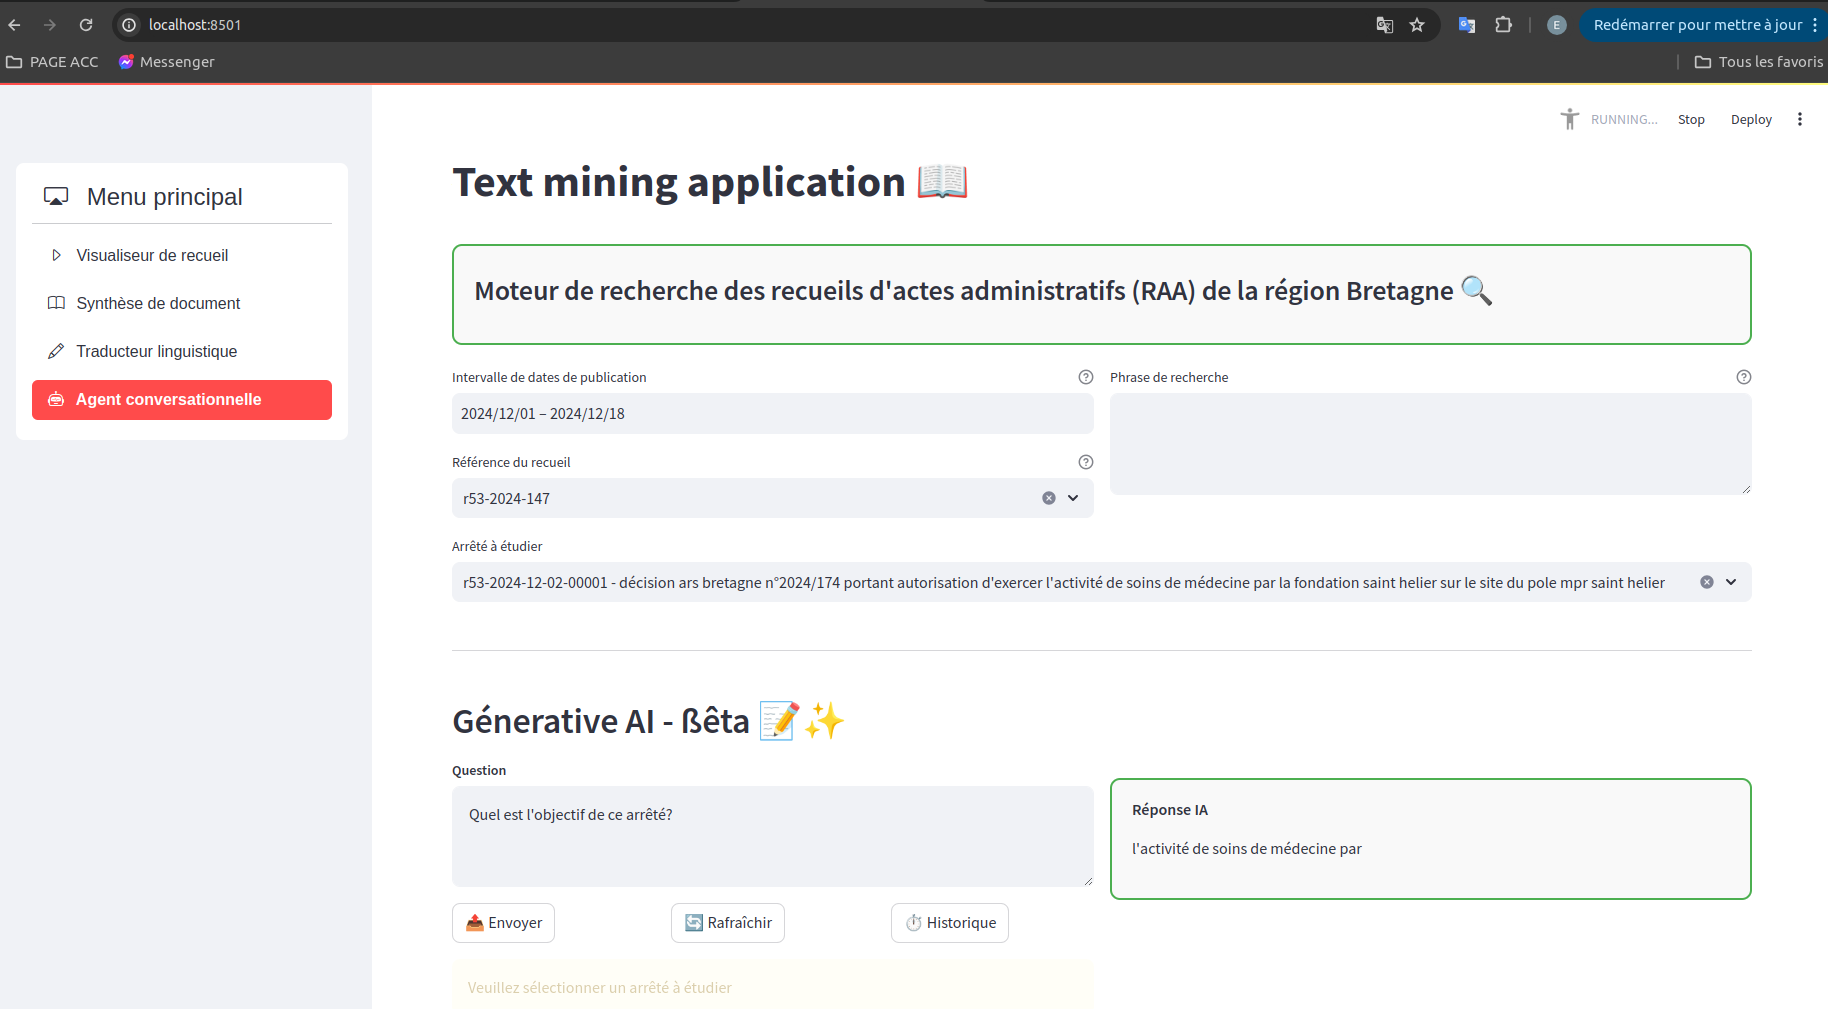

In [20]:
Image(filename= "images/synthetiseur.png")